# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Usage

1. Go through the [paper] to understand what the data is about.
1. Download some datasets from <https://github.com/mdeff/fma>.
1. Uncompress the archives, e.g. with `unzip fma_small.zip`.
1. Load and play with the data in this notebook.

[paper]: https://arxiv.org/abs/1612.01840

In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
import ast


import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 53), (163, 4), (106574, 518), (13129, 249))

## 1 Metadata

The metadata table, a CSV file in the `fma_metadata.zip` archive, is composed of many colums:
1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [3]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


### 1.1 Subsets

The small and medium subsets can be selected with the below code.

In [4]:
tracks.loc[tracks['subset']=='small']

album                                                              \
         comments        date_created date_released        engineer favorites   
track_id                                                                        
2               0 2008-11-26 01:44:45    2009-01-05             NaN         4   
5               0 2008-11-26 01:44:45    2009-01-05             NaN         4   
10              0 2008-11-26 01:45:08    2008-02-06             NaN         4   
140             1 2008-11-26 01:49:59    2007-05-22             NaN         1   
141             0 2008-11-26 01:49:57    2009-01-16             NaN         1   
...           ...                 ...           ...             ...       ...   
154308          0 2017-03-05 04:57:38    2017-03-05             NaN         0   
154309          0 2017-03-05 04:57:38    2017-03-05             NaN         0   
154413          0 2017-03-07 18:44:11           NaT  Ernie Indradat         0   
154414          0 2017-03-07 18:44:11           NaT  Ernie Indradat         0   
155066          0 2017-03-24 19:40:34    2017-03-24        JBlanked         1   

                                                                            \
             id                                        information listens   
track_id                                                                     
2             1                                            <p></p>    6073   
5             1                                            <p></p>    6073   
10            6                                                NaN   47632   
140          61  <p>Alec K. Redfearn &amp; The Eyesores: Ellen ...    1300   
141          60  <p>A full ensamble of strings, drums, electron...    1304   
...         ...                                                ...     ...   
154308    22780                                                NaN   22334   
154309    22780                                                NaN   22334   
154413    22789  <p>A live performance at WFMU for Dark Night o...    3777   
154414    22789  <p>A live performance at WFMU for Dark Night o...    3777   
155066    22899  <p>Hip Hop, Old School type beat 2017, Trap Mu...    4524   

                                          \
                                producer   
track_id                                   
2                                    NaN   
5                                    NaN   
10                                   NaN   
140       Alec K. Refearn, Rob Pemberton   
141                                  NaN   
...                                  ...   
154308                           Fleslit   
154309                           Fleslit   
154413                     Julie Bennack   
154414                     Julie Bennack   
155066                          JBlanked   

                                                             ...    track  \
                                                       tags  ... interest   
track_id                                                     ...            
2                                                        []  ...     4656   
5                                                        []  ...     1933   
10                                                       []  ...    54881   
140                                                      []  ...     1593   
141                                                      []  ...      839   
...                                                     ...  ...      ...   
154308    [fleslit, trap beat free use, trap beat free d...  ...     3371   
154309    [fleslit, trap beat free use, trap beat free d...  ...     4525   
154413                                                   []  ...      809   
154414                                                   []  ...      851   
155066    [old school beats, 2017 free instrumentals, fr...  ...     2065   

                                                                           \
         la

In [5]:
small = tracks.loc[tracks['subset']=='small']
small.shape

(8000, 53)

In [6]:
medium = tracks[tracks['set', 'subset'] <= 'medium']
medium.shape

(98574, 53)

In [7]:
small.columns

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          

In [8]:
small['track','genre_top'].value_counts()

Rock                   1000
Pop                    1000
International          1000
Instrumental           1000
Hip-Hop                1000
Folk                   1000
Experimental           1000
Electronic             1000
Spoken                    0
Soul-RnB                  0
Old-Time / Historic       0
Jazz                      0
Easy Listening            0
Country                   0
Classical                 0
Blues                     0
Name: (track, genre_top), dtype: int64

In [9]:
small.isna()

album                                                       \
         comments date_created date_released engineer favorites     id   
track_id                                                                 
2           False        False         False     True     False  False   
5           False        False         False     True     False  False   
10          False        False         False     True     False  False   
140         False        False         False     True     False  False   
141         False        False         False     True     False  False   
...           ...          ...           ...      ...       ...    ...   
154308      False        False         False     True     False  False   
154309      False        False         False     True     False  False   
154413      False        False          True    False     False  False   
154414      False        False          True    False     False  False   
155066      False        False         False    False     False  False   

                                              ...    track                \
         information listens producer   tags  ... interest language_code   
track_id                                      ...                          
2              False   False     True  False  ...    False         False   
5              False   False     True  False  ...    False         False   
10              True   False     True  False  ...    False         False   
140            False   False    False  False  ...    False         False   
141            False   False     True  False  ...    False         False   
...              ...     ...      ...    ...  ...      ...           ...   
154308          True   False    False  False  ...    False          True   
154309          True   False    False  False  ...    False          True   
154413         False   False    False  False  ...    False          True   
154414         False   False    False  False  ...    False          True   
155066         False   False    False  False  ...    False          True   

                                                                 subset  
         license listens lyricist number publisher   tags  title         
track_id                                                                 
2          False   False     True  False      True  False  False  False  
5          False   False     True  False      True  False  False  False  
10         False   False     True  False      True  False  False  False  
140        False   False     True  False      True  False  False  False  
141        False   False     True  False      True  False  False  False  
...          ...     ...      ...    ...       ...    ...    ...    ...  
154308     False   False     True  False      True  False  False  False  
154309     False   False     True  False      True  False  False  False  
154413     False   False     True  False      True  False  False  False  
154414     False   False     True  False      True  False  False  False  
155066     False   False     True  False      True  False  False  False  

[8000 rows x 53 columns]

In [10]:
small['genre'] = small['track','genre_top']

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
small['duration'] = small['track','duration']

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
small.reset_index(inplace=True)

In [13]:
cols = ['track_id','genre','duration']

In [14]:
df = small[cols]

In [15]:
df

,track_id,genre,duration
,,,
0,2,Hip-Hop,168
1,5,Hip-Hop,206
2,10,Pop,161
3,140,Folk,253
4,141,Folk,182
...,...,...,...
7995,154308,Hip-Hop,194
7996,154309,Hip-Hop,162
7997,154413,Pop,349


## 2 Genres

The genre hierarchy is stored in `genres.csv` and distributed in `fma_metadata.zip`.

In [16]:
genres

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
...,...,...,...,...
1032,60,102,Turkish,2
1060,30,46,Tango,2
1156,26,130,Fado,2


In [17]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


In [18]:
genres.sort_values('#tracks').head(10)

,#tracks,parent,title,top_level
genre_id,,,,
175,0,86,Bollywood,2
178,0,4,Be-Bop,4
377,1,19,Deep Funk,14
173,4,86,N. Indian Traditional,2
493,4,651,Western Swing,9
374,9,20,Banter,20
808,12,46,Salsa,2
174,17,86,South Indian Traditional,2
465,18,20,Musical Theater,20


## 3 Features

1. Features extracted from the audio for all tracks.
2. For some tracks, data colected from the [Echonest](http://the.echonest.com/) API.

In [19]:
features

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   
...                ...       ...       ...       ...       ...       ...   
155316       -0.490129  0.463834  2.321970 -0.084352  1.662914  2.115189   
155317       -0.461559 -0.229601 -0.496632 -0.422033  0.130612 -0.263825   
155318        0.552473 -0.110498 -0.532014  0.263131 -0.224011 -0.530972   
155319       -0.176901  0.187208 -0.050664  0.368843  0.066005 -0.857354   
155320        0.489665  1.862421  0.854461 -0.103666 -0.249835  0.360283   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   
...              ...       ...       ...       ...  ...       ...       ...   
155316     -0.237794  5.695442  0.830353  1.951819  ...  0.128410  0.022547   
155317     -0.628103 -0.082687 -0.229483 -0.492753  ...  0.132964  0.023548   
155318      1.713526  1.418444  1.325197  0.120333  ...  0.108324  0.017540   
155319     -0.780860  0.626281 -0.630938 -0.787229  ...  0.088311  0.018328   
155320     -0.366701  0.033578 -0.834606 -1.154845  ...  0.091421  0.020312   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   
...              ...        ...       ...       ...       ...       ...   
155316      0.019816   4.448255  0.172852  0.028773  0.028320  0.003906   
155317      0.026527   3.270612  0.196289  0.031116  0.027832  0.002441   
155318      0.020471   2.356727  0.212891  0.038450  0.037109  0.003418   
155319      0.017936   6.188604  0.167480  0.041480  0.038086  0.004883   
155320      0.016794  21.756050  0.845215  0.075141  0.044434  0.004395   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  
...              ...       ...  
155316      0.955388  0.012385  
155317      1.283060  0.019059  
155318      0.828569  0.017904  
155319      1.818740  0.020133  
155320      4.687204  0.137205  

[106574 rows x 518 columns]

In [20]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


### 3.1 Echonest features

In [25]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())

249 features for 13129 tracks


,album_date,album_name,artist_latitude,artist_location,artist_longitude,artist_name,release
track_id,,,,,,,
2,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
3,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
5,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
10,2008-03-11,Constant Hitmaker,39.9523,"Philadelphia, PA, US",-75.1624,Kurt Vile,Constant Hitmaker
134,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
track_id,,,,,
2,0.388990,0.386740,0.406370,0.000000,0.000000
3,0.388990,0.386740,0.406370,0.000000,0.000000
5,0.388990,0.386740,0.406370,0.000000,0.000000
10,0.557339,0.614272,0.798387,0.005158,0.354516
134,0.388990,0.386740,0.406370,0.000000,0.000000


,artist_discovery_rank,artist_familiarity_rank,artist_hotttnesss_rank,song_currency_rank,song_hotttnesss_rank
track_id,,,,,
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
10,2635.0,2544.0,397.0,115691.0,67609.0
134,NaN,NaN,NaN,NaN,NaN


,000,001,002,003,004,005,006,007,008,009,...,214,215,216,217,218,219,220,221,222,223
track_id,,,,,,,,,,,,,,,,,,,,,
2,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
3,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
5,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
10,0.311404,0.711402,0.321914,0.500601,0.250963,0.321316,0.734250,0.325188,0.373012,0.235840,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
134,0.610849,0.569169,0.428494,0.345796,0.376920,0.460590,0.401371,0.449900,0.428946,0.446736,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


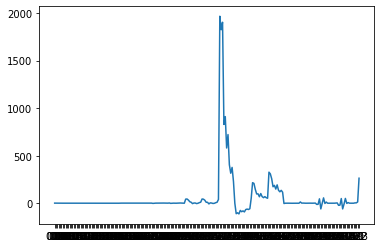

In [26]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[2, ('echonest', 'temporal_features')]
plt.plot(x);

### 3.2 Features like MFCCs are discriminant

((5631, 2), (5631,))

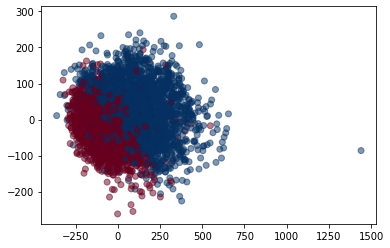

In [27]:
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

## 4 Audio

You can load the waveform and listen to audio in the notebook itself.

In [ ]:
'data/fma_small/000/000002.mp3'

In [57]:
import wave
w = wave.open('data/fma_small/000/000002.mp3',"r")

Error: file does not start with RIFF id

In [ ]:
import time
import librosa

s = time.time()
for i in mp3_list[:10]: # list of mp3 file paths, doing for 10 files
    y, sr = librosa.load(i)

print('time taken =', time.time() - s)

In [52]:
AUDIO_DIR = os.environ.get('AUDIO_DIR')


In [55]:
AUDIO_DIR = os.environ.get('AUDIO_DIR')
utils.get_audio_path(AUDIO_DIR, 2)


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [56]:
filename = utils.get_audio_path(AUDIO_DIR, 2)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

TypeError: expected str, bytes or os.PathLike object, not NoneType

And use [librosa](https://github.com/librosa/librosa) to compute spectrograms and audio features.

In [41]:
librosa.display.waveplot(x, sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));

NameError: name 'sr' is not defined

In [19]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.logamplitude(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

ParameterError: Audio data must be of type numpy.ndarray

In [ ]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');

## 5 Genre classification

### 5.1 From features

In [58]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

84353 training examples, 11263 testing examples


TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

### 5.2 From audio